# CIS 3120 Final Project
### By: Faraj Arvid

Installing necessary Python libraries

In [25]:
from API_key import API_KEY
import requests
import pandas as pd
import matplotlib.pyplot as plt

Setting up the API:

In [26]:
BASE_URL = 'https://v3.football.api-sports.io'

HEADERS = {
    'x-rapidapi-host': 'v3.football.api-sports.io',
    'x-rapidapi-key': API_KEY
}

# created dictionary for leagues to allow code reusability 
leagues = {
    39: "England",
    140: "Spain",
    135: "Italy",
    78: "Germany",
    61: "France"
}

season = 2022 # used because it is the latest season that is avaliable on the free version of the API

Incorporating OOP, Classes, and Child Classes to provide basic summary of the 5 leagues this project centers on:

In [27]:
class LeagueInfo:
    def __init__(self, league_id, name, reputation):
        self.league_id = league_id
        self.name = name
        self.reputation = reputation
        self.country = self.get_country()

    def get_country(self):
        return leagues.get(self.league_id)

    def info(self):
        return (f"{self.name} is based in {self.country}. "
                f"{self.name} is famous for {self.reputation}.\n")

class LeagueSummary(LeagueInfo):
    def __init__(self, league_id, name, trait1, trait2):
        super().__init__(league_id, name, reputation=None)
        self.trait1 = trait1
        self.trait2 = trait2

    def info(self):
        return (f"{self.name} is based in {self.country}. "
                f"{self.name} is known for {self.trait1} and {self.trait2}.\n")

test1 = LeagueInfo(39, "The Premier League", "being the most viewed and most challenging league in the world")
test2 = LeagueSummary(140, "La Liga", "playmaking/technical skills", "having the best midfielders")
test3 = LeagueSummary(135, "Serie A", "physical/rough play", "containing the strongest defenders")
test4 = LeagueInfo(78, "The Bundesliga", "providing opportunities for young players to develop into the stars of the future")
test5 = LeagueSummary(61, "Ligue 1", "chaotic, fast-paced action", "being full of tricky, speedy attackers")

for test in [test1, test2, test3, test4, test5]:
    print(test.info())

The Premier League is based in England. The Premier League is famous for being the most viewed and most challenging league in the world.

La Liga is based in Spain. La Liga is known for playmaking/technical skills and having the best midfielders.

Serie A is based in Italy. Serie A is known for physical/rough play and containing the strongest defenders.

The Bundesliga is based in Germany. The Bundesliga is famous for providing opportunities for young players to develop into the stars of the future.

Ligue 1 is based in France. Ligue 1 is known for chaotic, fast-paced action and being full of tricky, speedy attackers.



Method for fetching standings from 5 particular football leagues in 2022 and combining them all into one dataframe:

In [28]:
def get_standings(league_ids, season):
    all_standings = []
    
    for league_id, country in league_ids.items():
        url = f"{BASE_URL}/standings?league={league_id}&season={season}"
        response = requests.get(url, headers=HEADERS)
        standings_data = response.json()

        standings = standings_data['response'][0]['league']['standings'][0]

        league_standings_df = pd.DataFrame([{
            'Rank': team['rank'],
            'Team': team['team']['name'],
            'Points': team['points'],
            'Games Played': team['all']['played'],
            'Goals For': team['all']['goals']['for'],
            'Country': country
        } for team in standings])
        
        all_standings.append(league_standings_df)
    
    combined_standings_df = pd.concat(all_standings, ignore_index=True)
    return combined_standings_df

combined_standings = get_standings(leagues, season)
print(combined_standings)

    Rank               Team  Points  Games Played  Goals For  Country
0      1    Manchester City      89            38         94  England
1      2            Arsenal      84            38         88  England
2      3  Manchester United      75            38         58  England
3      4          Newcastle      71            38         68  England
4      5          Liverpool      67            38         75  England
..   ...                ...     ...           ...        ...      ...
93    16             Nantes      36            38         37   France
94    17            Auxerre      35            38         35   France
95    18            Ajaccio      26            38         23   France
96    19       Estac Troyes      24            38         45   France
97    20             Angers      18            38         33   France

[98 rows x 6 columns]


Data Manipulation of above dataframe (grouping, dropping columns, adding columns, etc) to create new dataframe that calculates the goals per game in each of the 5 leagues:

In [29]:
grouped = combined_standings.groupby('Country').sum()
cleaned = grouped.drop(['Rank','Team', 'Points'], axis=1) # dropped because they were not relavant for the analysis I wanted to conduct
cleaned['Games Played'] = cleaned['Games Played']/2 # necessary because every match involves two teams so value is double the actual value
cleaned['Goals Per Game'] = cleaned['Goals For']/cleaned['Games Played']
final = cleaned.sort_values(by='Goals Per Game') # sorting before graphing
final

,Games Played,Goals For,Goals Per Game
Country,,,
Spain,380.0,955,2.513158
Italy,380.0,974,2.563158
France,380.0,1067,2.807895
England,380.0,1084,2.852632
Germany,306.0,971,3.173203


### First Visualization Created

The below bar graph is created through a Class and shows the goals scored per game in each of the 5 leagues and compares the values to each other. The graph has a proper title, axes, and the bar graph values are labeled to provide precise values to use for analysis and insights.

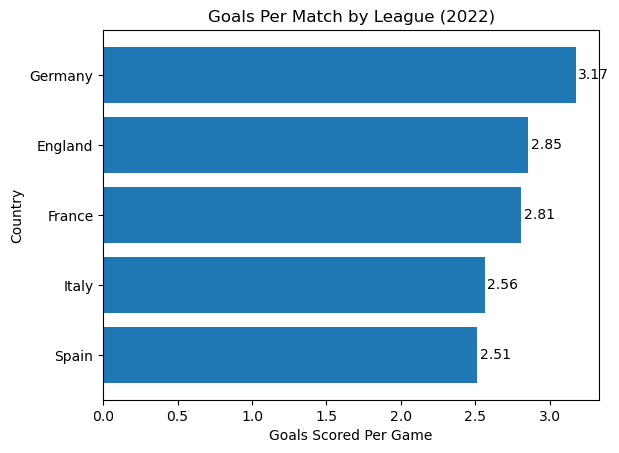

Analysis and explanation of the graph above is provided in the README file


In [30]:
class BarChart:
    def __init__(self, data, title, xlabel, ylabel):
        self.data = data
        self.title = title
        self.xlabel = xlabel
        self.ylabel = ylabel

    def generate_chart(self):
        bars = plt.barh(self.data.index, self.data['Goals Per Game'])
        plt.bar_label(bars, fmt='%.2f', padding=2)
        plt.xlabel(self.xlabel)
        plt.ylabel(self.ylabel)
        plt.title(self.title)
        self.show_chart()

    def show_chart(self):
        plt.show()
        print("Analysis and explanation of the graph above is provided in the README file")
        
bar_chart = BarChart(data=final, title="Goals Per Match by League (2022)", xlabel="Goals Scored Per Game", ylabel="Country")
bar_chart.generate_chart()

Method for fetching the top 20 players with the most red cards recieved from 5 particular football leagues in 2022 and combining them all into one dataframe:

In [31]:
def get_top_red_card_data():
    all_top_red_cards = []

    for league_id, country in leagues.items():
        url = f"{BASE_URL}/players/topredcards?league={league_id}&season={season}"
        response = requests.get(url, headers=HEADERS)
        data = response.json().get('response', [])

        top_red_cards = [{
            'Player': player['player']['name'],
            'Team': player['statistics'][0]['team']['name'],
            'Red Cards': player['statistics'][0]['cards']['red'],
            'League': country
        } for player in data]

        if top_red_cards:
            df_red_cards = pd.DataFrame(top_red_cards).set_index('Player')
            all_top_red_cards.append(df_red_cards)

    return pd.concat(all_top_red_cards)

final_df = get_top_red_card_data()
print(final_df)

                             Team  Red Cards   League
Player                                               
Casemiro        Manchester United          2  England
Nélson Semedo              Wolves          1  England
Douglas Luiz          Aston Villa          1  England
A. Doucouré               Everton          1  England
T. Mitchell        Crystal Palace          1  England
...                           ...        ...      ...
E. Wahi               Montpellier          1   France
A. Djiku               Strasbourg          1   France
K. Danso                     Lens          1   France
M. Wieteska         Clermont Foot          1   France
S. Abdul Samed               Lens          1   France

[100 rows x 3 columns]


Data Manipulation of above dataframe (grouping and dropping columns) to create new dataframe that calculates the total red cards accumulated in each of the 5 leagues:

In [32]:
print('Total amount of red cards across all leagues:', final_df['Red Cards'].sum())
cardDF = final_df.groupby('League').sum()
cardDF = cardDF.drop('Team', axis=1) # dropped because column was not relavant for the analysis I wanted to conduct
cardDF

Total amount of red cards across all leagues: 115


,Red Cards
League,
England,17
France,25
Germany,20
Italy,20
Spain,33


### Second Visualization Created

The below pie chart is created through a child Class and shows the distribution of red cards handed out to players across the 5 leagues. The graph has a proper title, labels, and the percent values are rounded and provided allowing for precise values to used for analysis and insights.

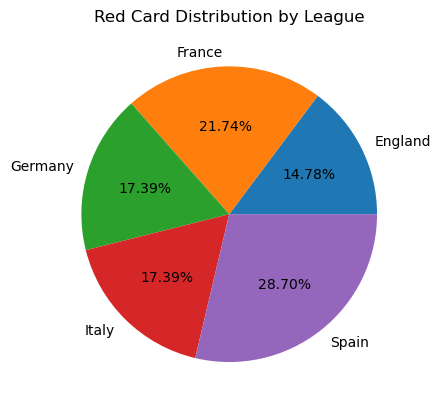

Analysis and explanation of the graph above is provided in the README file


In [33]:
class PieChart(BarChart):
    def __init__(self, data, title):
        super().__init__(data, title, xlabel=None, ylabel=None)

    def generate_chart(self):
        plt.pie(self.data['Red Cards'], labels=self.data.index, autopct='%1.2f%%')
        plt.title(self.title)
        self.show_chart()
        
pie_chart = PieChart(data=cardDF, title="Red Card Distribution by League")
pie_chart.generate_chart()